Install all needed libraries

In [1]:
%pip install pandas
%pip install scikit-learn
%pip install joblib
%pip install matplotlib
%pip install nltk
%pip install transformers
%pip install datasets
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 in

Extract the classic book names from https://www.oclc.org/en/worldcat/library100/top500.html. Use Open Library API to extract description and category and create an own dataset

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.oclc.org/en/worldcat/library100/top500.html"
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

rows = soup.select('table#lib500list tr')
book_titles = []

for row in rows:
    title_cell = row.find('td', class_='ti')
    
    if title_cell:
        title = title_cell.a.get_text(strip=True)
        book_titles.append(title)

print(len(book_titles))

# use Open Library to extract descriptions
book_data = []

for title in book_titles:
    search_url = f"https://openlibrary.org/search.json?title={requests.utils.quote(title)}"
    search_response = requests.get(search_url)
    if search_response.status_code == 200:
        search_result = search_response.json()
        if search_result['docs']:
            doc = search_result['docs'][0]
            work_key = doc.get('key', '')
            if work_key:
                work_url = f"https://openlibrary.org{work_key}.json"
                work_response = requests.get(work_url)
                if work_response.status_code == 200:
                    work_info = work_response.json()
                    description = work_info.get('description')
                    if isinstance(description, dict):  
                        description = description.get('value')
                    elif not isinstance(description, str):
                        description = None
                    subjects = work_info.get('subjects')
                    category = subjects[0] if subjects else None
                    book_data.append({
                        'title': title,
                        'description': description,
                        'categories': str(category).lower()
                    })
    time.sleep(1)

# save to CSV
df = pd.DataFrame(book_data)
print(df)
csv_path = "classic_books_data.csv"
df.to_csv(csv_path, index=False)

500
                                  title  \
0                           Don Quixote   
1      Alice's Adventures in Wonderland   
2    The Adventures of Huckleberry Finn   
3          The Adventures of Tom Sawyer   
4                       Treasure Island   
..                                  ...   
494          Stranger in a Strange Land   
495                     Vision in White   
496                    The Whipping Boy   
497                                Room   
498                     Deception Point   

                                           description  \
0    A PBS Great American Read Top 100 Pick\r\n\r\n...   
1    Alice's Adventures in Wonderland (commonly Ali...   
2                                                 None   
3    Mark Twain created the memorable characters To...   
4    Traditionally considered a coming-of-age story...   
..                                                 ...   
494  Stranger in a Strange Land is a 1961 science f...   
495  Childhood 

Data Cleaning and Preprocessing:


*   Load dataset (https://www.kaggle.com/datasets/abdallahwagih/books-dataset?resource=download)
*   Remove rows where description and category is not given
*   Keep only the first genre if multiple are present
*   Keep the most frequent genres only
*   Split the dataset into training and test set
*   Vectorize using TF-IDF



In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
import torch
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments


from nltk.corpus import stopwords
nltk.download('stopwords')

df = pd.read_csv("classic_books_data.csv")
df_clean = df.dropna(subset=["description", "categories"]).copy()
df_clean["main_category"] = df_clean["categories"].apply(lambda x: x.split(",")[0].strip())

# leave top 10 most frequent genres
top_categories = df_clean["main_category"].value_counts().nlargest(10).index.tolist()
df_top10 = df_clean[df_clean["main_category"].isin(top_categories)]

# prepare features (X) and labels (y)
X = df_top10["description"]
y = df_top10["main_category"]

# encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# training 80% and test 20% sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# vectorize descriptions
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, sublinear_tf=True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasiyadamaratskaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Models Training and Accuracy Computing

In [13]:
# Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)
y_pred_nb = model_nb.predict(X_test_vec)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Support Vector Machine (SVM)
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

Naive Bayes Accuracy: 0.6666666666666666
Logistic Regression Accuracy: 0.6666666666666666
Random Forest Accuracy: 0.6666666666666666
SVM Accuracy: 0.696969696969697


Training transformers

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"

# convert text and labels to list
train_texts = X_train.tolist()
test_texts = X_test.tolist()
train_labels = y_train.tolist()
test_labels = y_test.tolist()

# DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})
num_labels = len(set(train_labels))
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted')
    }

# training configuration
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# train & evaluate
trainer.train()
eval_result = trainer.evaluate()
print("Evaluation Results:", eval_result)

# save model and tokenizer
model.save_pretrained("./book_genre_classifier_model")
tokenizer.save_pretrained("./book_genre_classifier_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.167100,1.630764,0.666667,0.533333
2,1.378500,1.391047,0.666667,0.533333
3,1.288300,1.358217,0.666667,0.533333


Evaluation Results: {'eval_loss': 1.358216643333435, 'eval_accuracy': 0.6666666666666666, 'eval_f1': 0.5333333333333333, 'eval_runtime': 0.3124, 'eval_samples_per_second': 105.622, 'eval_steps_per_second': 16.003, 'epoch': 3.0}


('./book_genre_classifier_model/tokenizer_config.json',
 './book_genre_classifier_model/special_tokens_map.json',
 './book_genre_classifier_model/vocab.txt',
 './book_genre_classifier_model/added_tokens.json',
 './book_genre_classifier_model/tokenizer.json')

Classification Report for Naive Bayes

In [15]:
present_labels = unique_labels(y_test, y_pred_nb)
present_class_names = label_encoder.inverse_transform(present_labels)

report = classification_report(
    y_test, y_pred_nb,
    labels=present_labels,
    target_names=present_class_names,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()
top_f1 = report_df.sort_values(by="f1-score", ascending=False).head(10)

print("\nTop 10 genres by F1-score (Naive Bayes):")
print(top_f1)


Top 10 genres by F1-score (Naive Bayes):
                          precision    recall  f1-score    support
fiction                    0.666667  1.000000  0.800000  22.000000
accuracy                   0.666667  0.666667  0.666667   0.666667
weighted avg               0.444444  0.666667  0.533333  33.000000
macro avg                  0.095238  0.142857  0.114286  33.000000
fantasy                    0.000000  0.000000  0.000000   3.000000
fantasy fiction            0.000000  0.000000  0.000000   1.000000
juvenile fiction           0.000000  0.000000  0.000000   4.000000
open library staff picks   0.000000  0.000000  0.000000   1.000000
social life and customs    0.000000  0.000000  0.000000   1.000000
suspense & thriller        0.000000  0.000000  0.000000   1.000000


Confusion Matrix for Naive Bayes

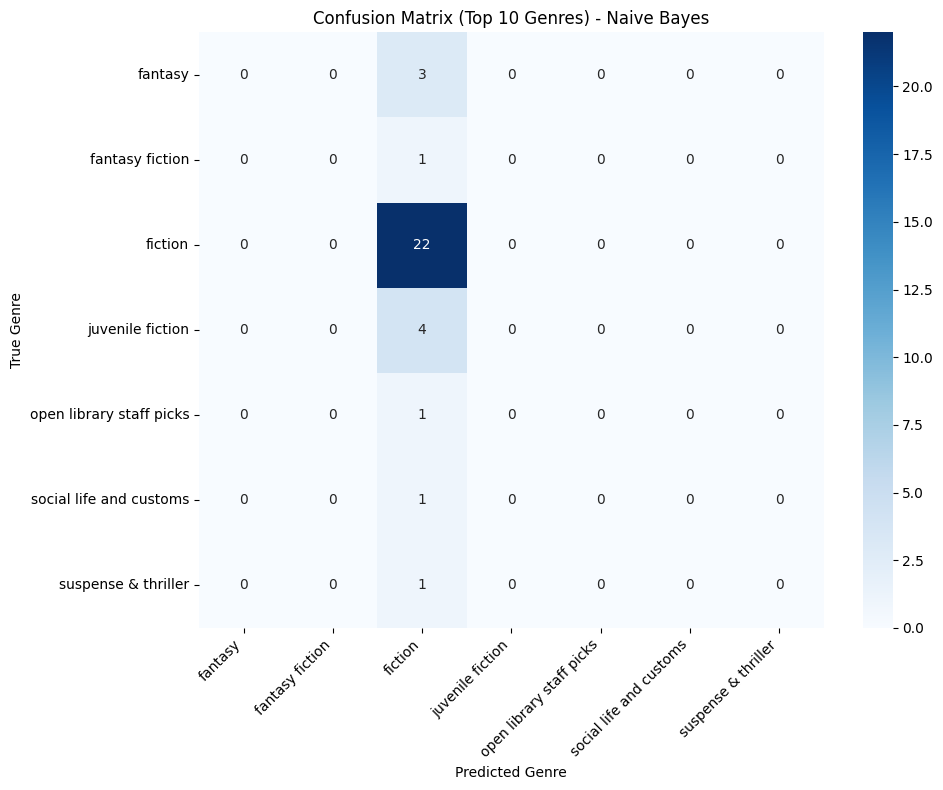

In [16]:
cm = confusion_matrix(y_test, y_pred_nb, labels=present_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.title("Confusion Matrix (Top 10 Genres) - Naive Bayes")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

F1-score Comparison


F1-score (weighted) for all models:
Naive Bayes: 0.5333
Logistic Regression: 0.5333
Random Forest: 0.5333
SVM: 0.5735
DistilBERT: 0.5333
Best model based on weighted F1-score: SVM (0.5735)


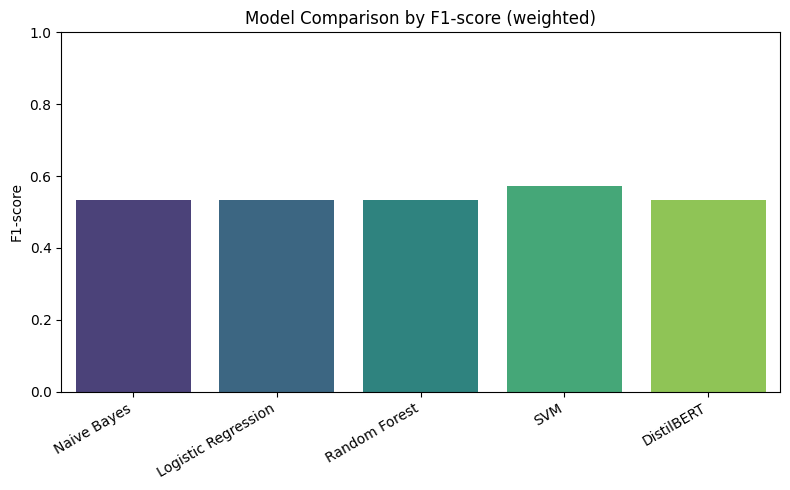

All models and preprocessing objects saved successfully.


In [17]:
f1_scores = {
    "Naive Bayes": f1_score(y_test, y_pred_nb, average="weighted", zero_division=0),
    "Logistic Regression": f1_score(y_test, y_pred_lr, average="weighted", zero_division=0),
    "Random Forest": f1_score(y_test, y_pred_rf, average="weighted", zero_division=0),
    "SVM": f1_score(y_test, y_pred_svm, average="weighted", zero_division=0),
    "DistilBERT" : eval_result.get("eval_f1")
}
# Print F1-scores
print("\nF1-score (weighted) for all models:")
for model_name, score in f1_scores.items():
    print(f"{model_name}: {score:.4f}")

# Find the best model
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_model_name]
print(f"Best model based on weighted F1-score: {best_model_name} ({best_f1_score:.4f})")

model_names = list(f1_scores.keys())
f1_vals = list(f1_scores.values())

# Plot F1-score comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=f1_vals, hue=model_names, palette="viridis", legend=False)
plt.title("Model Comparison by F1-score (weighted)")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# === Save all models and encoders ===
joblib.dump(model_nb, "genre_classifier_nb.pkl")
joblib.dump(log_reg, "genre_classifier_logreg.pkl")
joblib.dump(rf_model, "genre_classifier_rf.pkl")
joblib.dump(svm_model, "genre_classifier_svm.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("All models and preprocessing objects saved successfully.")